In [1]:
import os
import sys
import pathlib
import warnings
import numpy as np
import pandas as pd
from pprint import pprint
import tensorflow as tf
from lips.benchmark.powergridBenchmark import PowerGridBenchmark
from lips.augmented_simulators.tensorflow_models import LeapNet
from lips.dataset.scaler.powergrid_scaler import PowerGridScaler
from lips.utils import get_path

In [ ]:
# set some environment variables
sys.path.insert(0, "../../")

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.set_option('display.max_columns', None)

# 1. l2rpn_case14_sandbox grid

In [3]:
# indicate required paths
LIPS_PATH = pathlib.Path().resolve().parent.parent # it is supposed that the notebook had run from getting_started folder
DATA_PATH = LIPS_PATH / "reference_data" / "powergrid" / "l2rpn_case14_sandbox"
BENCH_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "benchmarks" / "l2rpn_case14_sandbox.ini"
SIM_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "simulators"
BASELINES_PATH = LIPS_PATH / "trained_baselines" / "powergrid"
TRAINED_BASELINES_PATH = LIPS_PATH / "trained_baselines" / "powergrid"
EVALUATION_PATH = LIPS_PATH / "evaluation_results" / "PowerGrid"
LOG_PATH = LIPS_PATH / "lips_logs.log"

## 1.1 Benchmark2: Risk assessment through contingency screening

In [4]:
benchmark2 = PowerGridBenchmark(benchmark_name="Benchmark2",
                                benchmark_path=DATA_PATH,
                                load_data_set=True,
                                log_path=LOG_PATH,
                                config_path=BENCH_CONFIG_PATH,
                               )

In [ ]:
topo_actions = benchmark2.config.get_option("dataset_create_params")["train"]["topo_actions"]

kwargs_tau = []
for el in topo_actions:
     kwargs_tau.append(el["set_bus"]["substations_id"][0])
pprint(kwargs_tau)

## LeapNet

In [ ]:
leap_net = LeapNet(name="tf_leapnet",                              
                   bench_config_path=BENCH_CONFIG_PATH,
                   bench_config_name="Benchmark2",
                   sim_config_path=SIM_CONFIG_PATH / "tf_leapnet.ini",
                   sim_config_name="DEFAULT", 
                   log_path=LOG_PATH,
                   loss = {"name": "mse"},
                   lr = 1e-4,
                   activation = tf.keras.layers.LeakyReLU(alpha=0.01),
                   sizes_enc=(),
                   sizes_main=(200, 200),
                   sizes_out=(),
                   topo_vect_to_tau="given_list",
                   kwargs_tau = kwargs_tau,
                   concatenate_tau = True,
                   layer = "resnet",
                   scale_main_layer = 200,
                   scale_input_dec_layer = 200,
                   mult_by_zero_lines_pred = False,
                   scaler = PowerGridScaler,
                   )

## Training

In [ ]:
leap_net.train(train_dataset=benchmark2.train_dataset,
               val_dataset=benchmark2.val_dataset,
               batch_size=128,
               epochs=400)

### Save the model

In [ ]:
SAVE_PATH = get_path(TRAINED_BASELINES_PATH, benchmark2)
leap_net.save(SAVE_PATH)

## Visualization

In [ ]:
tf.keras.utils.plot_model(
    leap_net._model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations= True)

In [ ]:
leap_net.summary()

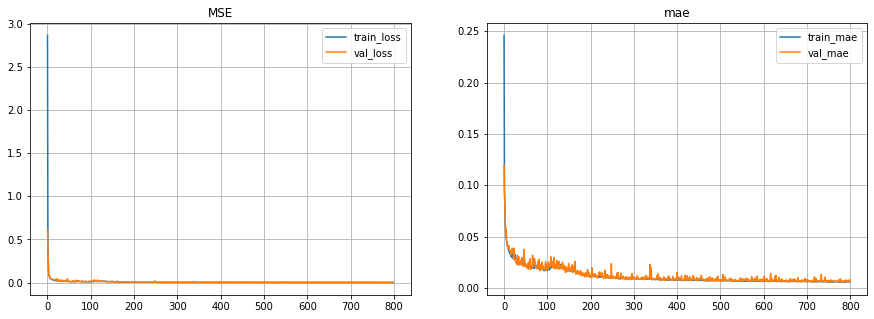

In [11]:
leap_net.visualize_convergence()

## Evaluation

In [ ]:
eval_metrics = benchmark2.evaluate_simulator(augmented_simulator=leap_net,
                                             eval_batch_size=128,
                                             dataset="all",
                                             shuffle=False,
                                             save_predictions=True
                                            )

## A 

In [ ]:
a_test_list = [eval_metrics["test"]["ML"]["mape_90_avg"]["a_or"], eval_metrics["test"]["ML"]["mape_90_avg"]["a_ex"]]
a_ood_list = [eval_metrics["test_ood_topo"]["ML"]["mape_90_avg"]["a_or"], eval_metrics["test_ood_topo"]["ML"]["mape_90_avg"]["a_ex"]]

In [ ]:
print("ML : MAPE90 --> A : mean :{}, std :{}".format(np.mean(a_test_list), np.std(a_test_list)))
print("OOD : MAPE90 --> A : mean :{}, std :{}".format(np.mean(a_ood_list), np.std(a_ood_list)))

## P

In [ ]:
p_test_list = [eval_metrics["test"]["ML"]["mape_avg"]["p_or"], eval_metrics["test"]["ML"]["mape_avg"]["p_ex"]]
p_ood_list = [eval_metrics["test_ood_topo"]["ML"]["mape_avg"]["p_or"], eval_metrics["test_ood_topo"]["ML"]["mape_avg"]["p_ex"]]

In [ ]:
print("ML : MAPE --> P : mean :{}, std :{}".format(np.mean(p_test_list), np.std(p_test_list)))
print("OOD : MAPE --> P : mean :{}, std :{}".format(np.mean(p_ood_list), np.std(p_ood_list)))

## V 

In [ ]:
v_test_list = [eval_metrics["test"]["ML"]["MAE_avg"]["v_or"], eval_metrics["test"]["ML"]["MAE_avg"]["v_ex"]]
v_ood_list = [eval_metrics["test_ood_topo"]["ML"]["MAE_avg"]["v_or"], eval_metrics["test_ood_topo"]["ML"]["MAE_avg"]["v_ex"]]

In [ ]:
print("ML : MAE --> V : mean :{}, std :{}".format(np.mean(v_test_list), np.std(v_test_list)))
print("OOD : MAE --> V : mean :{}, std :{}".format(np.mean(v_ood_list), np.std(v_ood_list)))

## Inf speed-up

In [ ]:
print("ML : Inf speed-up :", eval_metrics["test"]["ML"]["TIME_INF"])

## Physics ML

In [ ]:
print("1) Current positivity violation:", (eval_metrics["test"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"]+eval_metrics["test"]["Physics"]["CURRENT_POS"]["a_ex"]["Violation_proportion"])/2)#["a_or"]["Violation_proportion"]
print("2) Voltage positivity violation:", (eval_metrics["test"]["Physics"]["VOLTAGE_POS"]["v_or"]["Violation_proportion"]+eval_metrics["test"]["Physics"]["VOLTAGE_POS"]["v_ex"]["Violation_proportion"])/2)
print("3) Loss positivity violation:", eval_metrics["test"]["Physics"]["LOSS_POS"]["violation_proportion"])
print("4) Disconnected lines violation:", eval_metrics["test"]["Physics"]["DISC_LINES"])
print("5) Violation of loss to be between [1,4]% of production:", eval_metrics["test"]["Physics"]["CHECK_LOSS"]["violation_percentage"])
print("6) Violation of global conservation: {}% and its weighted mape: {}".format(eval_metrics["test"]["Physics"]["CHECK_GC"]["violation_percentage"], eval_metrics["test"]["Physics"]["CHECK_GC"]["wmape"]))
print("7) Violation of local conservation: {}% and its weighted mape: {}".format(eval_metrics["test"]["Physics"]["CHECK_LC"]["violation_percentage"], eval_metrics["test"]["Physics"]["CHECK_LC"]["mape"]))
print("8) Violation proportion of voltage equality at subs:", eval_metrics["test"]["Physics"]["CHECK_VOLTAGE_EQ"]["prop_voltages_violation"])

## Physics OOD

In [ ]:
print("1) Current positivity violation:", (eval_metrics["test_ood_topo"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"]+eval_metrics["test_ood_topo"]["Physics"]["CURRENT_POS"]["a_ex"]["Violation_proportion"])/2)#["a_or"]["Violation_proportion"]
print("2) Voltage positivity violation:", (eval_metrics["test_ood_topo"]["Physics"]["VOLTAGE_POS"]["v_or"]["Violation_proportion"]+eval_metrics["test_ood_topo"]["Physics"]["VOLTAGE_POS"]["v_ex"]["Violation_proportion"])/2)
print("3) Loss positivity violation:", eval_metrics["test_ood_topo"]["Physics"]["LOSS_POS"]["violation_proportion"])
print("4) Disconnected lines violation:", eval_metrics["test_ood_topo"]["Physics"]["DISC_LINES"])
print("5) Violation of loss to be between [1,4]% of production:", eval_metrics["test_ood_topo"]["Physics"]["CHECK_LOSS"]["violation_percentage"])
print("6) Violation of global conservation: {}% and its weighted mape: {}".format(eval_metrics["test_ood_topo"]["Physics"]["CHECK_GC"]["violation_percentage"], eval_metrics["test_ood_topo"]["Physics"]["CHECK_GC"]["wmape"]))
print("7) Violation of local conservation: {}% and its weighted mape: {}".format(eval_metrics["test_ood_topo"]["Physics"]["CHECK_LC"]["violation_percentage"], eval_metrics["test_ood_topo"]["Physics"]["CHECK_LC"]["mape"]))
print("8) Violation proportion of voltage equality at subs:", eval_metrics["test_ood_topo"]["Physics"]["CHECK_VOLTAGE_EQ"]["prop_voltages_violation"])